In [44]:
from itertools import combinations

import pandas as pd
import numpy as np
import os
import datetime
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")


In [45]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir,
                 "analysis_06_mann_whitney"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [46]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
import pprint

figure_2 = config.figure2
figure_4 = config.figure4
colors = config.figure_palette

colors

#pprint.pprint(figure_4.model_dump())

FigurePalette(default_bar='black', default_hist='lightgrey', default_dot='dimgray', dot_alpha=0.8, box_median_props={'linewidth': 2}, cat_palette='colorblind', text_fontsize=10)

In [48]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]

df_cpvt_unique_by_patient = df_cpvt.drop_duplicates(subset="individual_id")

# MUST REMOVE DUPLICATES BECAUSE IT VIOLATES THE
# INDEPENDENCE ASSUMPTION OF STATISTICAL TESTS
df_cpvt_analysis = df_cpvt.drop_duplicates(subset="individual_id", keep=False)

AGE_OF_ONSET_COL = "age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1"

In [49]:
print(f"Number of CPVT patients: {len(df_cpvt_unique_by_patient)}")
print(
    f"Number of patients that can be used for analysis: {len(df_cpvt_analysis)}")

Number of CPVT patients: 964
Number of patients that can be used for analysis: 963


In [50]:
from analysis.database import FigureParams
from typing import Literal, TypedDict


def set_figure_size(
        figure_params: FigureParams,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        x_tick_rotation: int = 0,
):
    plt.xlabel(figure_params.xlabel, fontsize=figure_params.x_label_fontsize)
    plt.ylabel(figure_params.ylabel, fontsize=figure_params.y_label_fontsize)
    plt.title(figure_params.title, fontsize=figure_params.title_fontsize)
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha,
               fontsize=figure_params.x_tick_fontsize)
    plt.yticks(fontsize=figure_params.y_tick_fontsize)
    sns.despine()
    plt.tight_layout()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir, name + '.' + fmt), dpi=300)


def convert_pvalue_to_asterisks(p_value: float, star_mode: str = "*"):
    if p_value <= 0.0001:
        return star_mode * 3
    elif p_value <= 0.001:
        return star_mode * 3
    elif p_value <= 0.01:
        return star_mode * 2
    elif p_value <= 0.05:
        return star_mode
    return ""

In [51]:
from analysis.write_report import PdfSection

report: dict[str, PdfSection] = {}

## Figure 2, Panel B

In [52]:
def get_median_and_mean(df_calc: pd.DataFrame):
    mean = df_calc[AGE_OF_ONSET_COL].mean()
    median = df_calc[AGE_OF_ONSET_COL].median()
    q1 = df_calc[AGE_OF_ONSET_COL].quantile(0.25)
    q3 = df_calc[AGE_OF_ONSET_COL].quantile(0.75)

    return mean, median, q1, q3


# print stats: mean, median, iqr
def print_median_and_iqr(df_calc: pd.DataFrame, name: str):
    mean, median, q1, q3 = get_median_and_mean(df_calc)

    stats_str = f"{name}: mean={mean:.2f}, median={median:.2f}, IQR={q1:.2f}-{q3:.2f}, n={len(df_calc)}"
    print(
        stats_str
    )

    return stats_str


age_onset_info = print_median_and_iqr(
    df_cpvt_unique_by_patient[
        df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()],
    "CPVT1 (all)"
)


CPVT1 (all): mean=13.32, median=11.00, IQR=7.00-14.00, n=409


In [53]:
# see if any are non integerr values
df_age_onset_graph_prev = df_cpvt_unique_by_patient[
    df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()][
    ["individual_id", AGE_OF_ONSET_COL]]
df_age_onset_graph_prev[
    df_age_onset_graph_prev[AGE_OF_ONSET_COL] % 1 != 0
    ]

,individual_id,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1
505,509,0.92
789,795,6.50
1212,1221,0.13


In [54]:
# floor the age of onset
df_age_onset_graph = df_age_onset_graph_prev.copy()
df_age_onset_graph[AGE_OF_ONSET_COL] = df_age_onset_graph[
    AGE_OF_ONSET_COL].apply(
    np.floor).astype(int)

df_age_onset_graph = df_age_onset_graph.groupby(AGE_OF_ONSET_COL).agg({
    "individual_id": "count"
})

df_age_onset_graph = df_age_onset_graph.join(
    pd.DataFrame({
        "age": np.arange(
            # must add + 1 since it actually does range from 0 -> max_age (inclusive)
            int(df_age_onset_graph_prev[AGE_OF_ONSET_COL].max() + 1)).astype(
            float)
    }).set_index("age"),
    how="right",
).reset_index()

df_age_onset_graph.columns = [AGE_OF_ONSET_COL, "count"]
df_age_onset_graph.fillna(0, inplace=True)

df_age_onset_graph.head()

,age_of_onset::Catecholaminergic polymorphic ventricular tachycardia 1,count
0,0.0,3.0
1,1.0,4.0
2,2.0,7.0
3,3.0,14.0
4,4.0,13.0


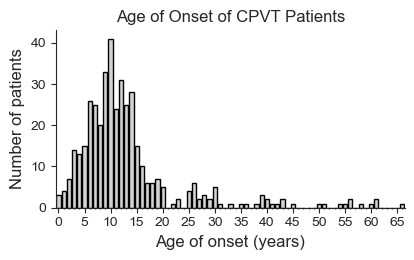

In [55]:
# FIGURE 2

fig2_panel_b = figure_2.panels["panel_b"]

plt.figure(figsize=fig2_panel_b.fig_size)

ax = plt.gca()

sns.barplot(
    data=df_age_onset_graph,
    x=AGE_OF_ONSET_COL,
    y="count",
    color=colors.default_hist,
    edgecolor="black",
    legend=False,
    ax=ax
)

x_tick_range = range(int(df_age_onset_graph[AGE_OF_ONSET_COL].max() + 1))
ax.set_xticks(x_tick_range)


def x_major_tick(x_val: int):
    return (x_val + 0) % 5 == 0


ax.set_xticklabels([
    x if x_major_tick(x) else "" for x in x_tick_range
])

# _, median_age_onset_global, _, _ = get_median_and_mean(
#     df_cpvt_unique_by_patient[
#         df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].notnull()])
# plt.axvline(
#     median_age_onset_global,
#     color='r',
#     linestyle='dashed',
#     linewidth=1,
#     label=f"Median: {median_age_onset_global:.2f}"
# )

for tick in ax.get_xticklines():
    if not x_major_tick(tick.get_xdata()[0]):
        tick.set_markersize(1)

sns.despine()

set_figure_size(fig2_panel_b)

plt.grid(False)
plt.tight_layout()

for fmt in ["png", "pdf", "svg"]:
    plt.savefig(
        os.path.join(figures_dir, f"hist_age_of_onset.{fmt}"), format=fmt,
        dpi=300
    )

plt.show()

In [56]:
# calculate skewness and kurtosis
skewness = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].skew()
kurtosis = df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].kurtosis()

skew_kurt_str = f"Skewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}"

skew_kurt_str

'Skewness: 2.43, Kurtosis: 6.85'

In [57]:
df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].mean()

13.324083129584352

In [58]:
report["age_onset_global"] = PdfSection(
    section="Age of Onset Summary",
    stuff=[
        age_onset_info,
        skew_kurt_str
    ]
)

## Age of onset vs Exon

In [59]:
MIN_NUM_INDIVIDUALS = 5

In [60]:
def get_stats_df(gb_df: pd.DataFrame, gb_column: str, sort_values="median"):
    stats_to_use = ['mean', 'median', lambda x: x.quantile(0.25),
                    lambda x: x.quantile(0.75), 'count']

    df_stats = gb_df.groupby(gb_column).agg({
        AGE_OF_ONSET_COL: stats_to_use,
    })

    df_stats.columns = ['mean', 'median', 'q1', 'q3', 'n']

    df_stats.reset_index(inplace=True)

    df_stats.sort_values(by=sort_values, ascending=True, inplace=True)

    return df_stats

In [61]:
def get_filtered_df(
        df_input: pd.DataFrame,
        group_col: str,
        change_type_col: str,
        min_num_individuals: int
):
    df_filtered = df_input.dropna(subset=[AGE_OF_ONSET_COL, group_col])
    # only missense bc our simple simple test can only handle that and other
    # types theoretically can span multiple exons/domains/etc...
    df_filtered = df_filtered[
        df_filtered[change_type_col] == "Substitution"
        ]
    # only individuals that have no more than 1 mutation
    # (basically like 100% of the data but just in case)
    df_filtered = df_filtered.drop_duplicates(subset=["individual_id"],
                                              keep=False)
    df_filtered = df_filtered[
        [
            "individual_id",
            AGE_OF_ONSET_COL,
            group_col,
        ]
    ]

    df_filtered_gt_5 = df_filtered[
        df_filtered[group_col].isin(
            df_filtered[group_col].value_counts()[
                lambda x: x >= min_num_individuals].index
        )
    ].copy()

    n_patients_removed = (
            df_filtered["individual_id"].nunique() -
            df_filtered_gt_5["individual_id"].nunique()
    )
    n_cats_analysis = df_filtered_gt_5[group_col].nunique()
    n_patients_analysis = df_filtered_gt_5["individual_id"].nunique()

    return df_filtered, df_filtered_gt_5, {
        "n_patients_removed": n_patients_removed,
        "n_cats_analysis": n_cats_analysis,
        "n_patients_analysis": n_patients_analysis
    }


filtered_exons, filtered_exon_for_analysis, stats_exon = get_filtered_df(
    df_cpvt_analysis,
    "exon_start",
    "protein_change_type",
    MIN_NUM_INDIVIDUALS
)
filtered_exon_for_analysis["exon_start"] = filtered_exon_for_analysis[
    "exon_start"].astype(int)
filtered_exons["exon_start"] = filtered_exons["exon_start"].astype(int)

# print which exons removed, how many patients
exons_removed = set(filtered_exons["exon_start"]) - set(
    filtered_exon_for_analysis["exon_start"])
print(
    f"Exons removed: {exons_removed}, n_patients_removed: {stats_exon['n_patients_removed']}"
)
print(stats_exon)

Exons removed: {3, 6, 13, 19, 27, 30, 34, 35, 36, 42, 50, 60, 65, 75, 77, 83, 84, 92, 95, 96, 103, 104}, n_patients_removed: 38
{'n_patients_removed': 38, 'n_cats_analysis': 22, 'n_patients_analysis': 320}


In [62]:
exon_sum_stats = get_stats_df(filtered_exon_for_analysis,
                              'exon_start').sort_values("exon_start")

exon_sum_stats["exon_start"] = exon_sum_stats["exon_start"].astype(int)

exon_sum_stats.head()

,exon_start,mean,median,q1,q3,n
0,8,13.705882,11.5,7.25,16.75,34
1,14,14.574468,12.0,9.50,16.50,47
2,15,10.320000,11.0,10.00,12.00,6
3,37,9.236667,10.0,9.00,10.00,9
4,43,15.500000,13.0,11.00,13.75,8


### Mann Whitney U Test

Exons for analysis groups vs age of onset of all others (that can be used for analysis)

In [63]:
from scipy import stats

stats.mannwhitneyu([1, 2, 3, 4, 5], [5, 4, 7, 7, 7])

MannwhitneyuResult(statistic=2.0, pvalue=0.0333386832715863)

In [64]:
import pingouin as pg

pg.mwu([1, 2, 3, 4, 5], [5, 4, 7, 7, 7])

,U-val,alternative,p-val,RBC,CLES
MWU,2.0,two-sided,0.033339,-0.84,0.08


Copied from rcompanion website: https://rcompanion.org/handbook/F_04.html

(NOTE: Cliff delta or glass rank biserial actually ranges from -1 to 1).


| **Measure**               | **Small**              | **Medium**             | **Large**              |
|---------------------------|------------------------|------------------------|------------------------|
| **r**                     | 0.10 – < 0.30         | 0.30 – < 0.50         | ≥ 0.50                |
| **tau-b**                 | 0.10 – < 0.30         | 0.30 – < 0.50         | ≥ 0.50                |
| **Cliff’s delta or rg**   | 0.11 – < 0.28         | 0.28 – < 0.43         | ≥ 0.43                |
| **Vargha and Delaney’s A**| 0.56 – < 0.64         | 0.64 – < 0.71         | ≥ 0.71                |
|                           | > 0.34 – 0.44         | > 0.29 – 0.34         | ≤ 0.29                |
| **Freeman’s theta**       | 0.11 – < 0.34         | 0.34 – < 0.58         | ≥ 0.58                |
| **epsilon-squared**       | 0.01 – < 0.08         | 0.08 – < 0.26         | ≥ 0.26                |


In [65]:
from statsmodels.stats.multitest import multipletests


# class ResultsMannWhitney(TypedDict):
#     group: int | str
#     u_statistic: float
#     pvalue: float
#     n_in_group: int
#     n_out_group: int
#     rank_biserial: float
#     vda: float
#     "effect_size (cliff)": Literal["small", "medium", "large",]
#     direction: Literal["greater", "less"]


def get_effect_size(measure: float,
                    measure_name: Literal["cliff", "vda"]) -> Literal[
                                                                  "small",
                                                                  "medium",
                                                                  "large"
                                                              ] | None:
    if measure_name == "cliff":
        if 0.11 < np.abs(measure) <= 0.28:
            return "small"
        elif 0.28 < np.abs(measure) < 0.43:
            return "medium"
        elif np.abs(measure) >= 0.43:
            return "large"
        else:
            return None
    elif measure_name == "vda":
        if 0.56 < measure <= 0.64 or 0.34 < measure <= 0.44:
            return "small"
        elif 0.64 < measure <= 0.71 or 0.29 < measure <= 0.34:
            return "medium"
        elif measure >= 0.71 or measure <= 0.29:
            return "large"
        else:
            return None
    else:
        return None


def get_mann_whitney(
        df_input: pd.DataFrame,
        *,
        df_all_data: pd.DataFrame | None = None,
        group_col: str,
) -> pd.DataFrame:
    """
    Calculates the mann whitney for all group vs Other
    Args:
        df_input: Input dataframe
        df_all_data: If this is None, then Other group is from only the df_input. Otherwise, Other group
            will be calculated from df_all_data
        group_col: Column to group by

    Returns: df with results

    """

    results = []

    df_for_other = df_all_data if df_all_data is not None else df_input

    for group_name in df_input[group_col].unique():
        in_group = df_input[df_input[group_col] == group_name][AGE_OF_ONSET_COL]
        out_group = df_for_other[df_for_other[group_col] != group_name][
            AGE_OF_ONSET_COL]

        mwu_res = pg.mwu(in_group, out_group)

        a_vs_b = mwu_res["CLES"].iloc[0]
        direction = "greater"
        if mwu_res["RBC"].iloc[0] < 0:
            direction = "less"
            a_vs_b = 1 - a_vs_b

        results.append({
            "group": group_name,
            "u_statistic": mwu_res["U-val"].iloc[0],
            "pvalue": mwu_res["p-val"].iloc[0],
            "n_in_group": len(in_group),
            "n_out_group": len(out_group),
            "cliff_delta": mwu_res["RBC"].iloc[0],
            "vda": mwu_res["CLES"].iloc[0],
            "effect_size (cliff)": get_effect_size(mwu_res["RBC"].iloc[0],
                                                   "cliff"),
            "effect_size (vda)": get_effect_size(mwu_res["CLES"].iloc[0],
                                                 "vda"),
            "direction": direction,
            "interpretation": f"There is a {a_vs_b * 100:.2f}% chance that a randomly selected value in group {group_name} "
                              f"will be {direction} than a randomly selected value in the other group"
        })

        res_df = pd.DataFrame(results)

        _, qvals, _, _ = multipletests(
            res_df["pvalue"],
            method="fdr_bh"
        )

        res_df["qvalue"] = qvals

    return res_df


exon_mw_all = get_mann_whitney(filtered_exon_for_analysis,
                               df_all_data=filtered_exons,
                               group_col="exon_start")
exon_mw_all[
    exon_mw_all["pvalue"] < 0.05
    ].sort_values("group")

,group,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
9,14,9184.0,0.004492,47,311,0.256619,0.628310,small,small,greater,There is a 62.83% chance that a randomly selec...,0.026687
7,45,225.0,0.000930,6,352,-0.786932,0.106534,large,large,less,There is a 89.35% chance that a randomly selec...,0.020455
20,88,1599.0,0.012944,15,343,-0.378426,0.310787,medium,medium,less,There is a 68.92% chance that a randomly selec...,0.047461
16,89,1629.5,0.022349,6,352,0.543087,0.771544,large,large,greater,There is a 77.15% chance that a randomly selec...,0.070241
10,90,6379.5,0.008949,54,304,-0.222770,0.388615,small,small,less,There is a 61.14% chance that a randomly selec...,0.039377
13,93,2214.0,0.004852,8,350,0.581429,0.790714,large,large,greater,There is a 79.07% chance that a randomly selec...,0.026687
17,102,302.0,0.002665,6,352,-0.714015,0.142992,large,large,less,There is a 85.70% chance that a randomly selec...,0.026687


In [66]:
# exon_mw_samples = get_mann_whitney(filtered_exon_for_analysis,
#                                    group_col="exon_start")
#
# exon_mw_samples["group"] = exon_mw_samples["group"].astype(int)
# exon_mw_samples[
#     exon_mw_samples["qvalue"] < 0.05
#     ].sort_values("group")

In [67]:
exon_with_stats = exon_sum_stats.join(
    exon_mw_all.set_index("group"),
    on="exon_start",
    how="outer"
)
NUM_SIG_FIGS = 1
exon_with_stats["mean"] = exon_with_stats["mean"].round(NUM_SIG_FIGS)
exon_with_stats["median"] = exon_with_stats["median"].round(NUM_SIG_FIGS)
exon_with_stats["q1"] = exon_with_stats["q1"].round(NUM_SIG_FIGS)
exon_with_stats["q3"] = exon_with_stats["q3"].round(NUM_SIG_FIGS)

# drop column exon_start_mw
# exon_with_stats.drop(columns="exon_start_mw", inplace=True)

exon_with_stats.to_csv(
    figures_dir / "exon_age_of_onset_stats.csv", index=False)

exon_with_stats

,exon_start,mean,median,q1,q3,n,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
0,8,13.7,11.5,7.2,16.8,34,6156.0,0.258356,34,324,0.117647,0.558824,small,None,greater,There is a 55.88% chance that a randomly selec...,0.355240
1,14,14.6,12.0,9.5,16.5,47,9184.0,0.004492,47,311,0.256619,0.628310,small,small,greater,There is a 62.83% chance that a randomly selec...,0.026687
2,15,10.3,11.0,10.0,12.0,6,1067.0,0.966610,6,352,0.010417,0.505208,None,None,greater,There is a 50.52% chance that a randomly selec...,0.966610
3,37,9.2,10.0,9.0,10.0,9,1357.0,0.486231,9,349,-0.135944,0.432028,small,small,less,There is a 56.80% chance that a randomly selec...,0.594283
4,43,15.5,13.0,11.0,13.8,8,1799.5,0.167122,8,350,0.285357,0.642679,medium,medium,greater,There is a 64.27% chance that a randomly selec...,0.282822
5,44,10.6,12.0,8.0,13.0,13,2303.0,0.869616,13,345,0.026979,0.513489,None,None,greater,There is a 51.35% chance that a randomly selec...,0.933947
6,45,4.5,4.5,3.2,5.0,6,225.0,0.000930,6,352,-0.786932,0.106534,large,large,less,There is a 89.35% chance that a randomly selec...,0.020455
7,46,13.3,11.0,8.0,13.0,11,1955.0,0.891494,11,347,0.024365,0.512182,None,None,greater,There is a 51.22% chance that a randomly selec...,0.933947
8,47,9.5,10.0,9.0,10.0,21,3000.5,0.241754,21,337,-0.152042,0.423979,small,small,less,There is a 57.60% chance that a randomly selec...,0.354757
9,49,8.4,9.0,7.5,11.0,11,1425.5,0.152471,11,347,-0.253078,0.373461,small,small,less,There is a 62.65% chance that a randomly selec...,0.279530


In [68]:
report["exon"] = PdfSection(
    section="Age of Onset vs Exon",
    stuff=[
        f"Number of exons for MW-U: {filtered_exon_for_analysis["exon_start"].nunique()}",
        f"Mean (all exons): {filtered_exons[AGE_OF_ONSET_COL].mean():.2f}",
        f"Median (all exons): {filtered_exons[AGE_OF_ONSET_COL].median():.2f}. IQR: {filtered_exons[AGE_OF_ONSET_COL].quantile(0.25):.2f}-{filtered_exons[AGE_OF_ONSET_COL].quantile(0.75):.2f}",
        f"Total number patients (all exons): {len(filtered_exons)}",
        # f"Kruskal-Wallis H-test: H={stat_exon:.2f}, P={p_exon:.2g}, n={len(filtered_exon)}",
        exon_mw_all[
            exon_mw_all["pvalue"] < 0.05
            ].sort_values("group")

    ]
)

In [69]:
import colorcet as cc

In [70]:
def add_stars_on_box(
        curr_ax: plt.Axes,
        x_vals: list,
        results: pd.DataFrame,
        y_pos: list[float],
        *,
        color: str = "black",
        offset: float = 5,
        stars: str = "*",
        sig_value: Literal["pvalue", "qvalue"] = "qvalue"
):
    if len(x_vals) != len(y_pos):
        raise ValueError("x_vals and y_heights must have the same length")

    for i, (x_val, y_pos_i) in enumerate(zip(x_vals, y_pos)):

        p_val = results[results["group"] == x_val][sig_value].values[0]

        if p_val >= 0.05:
            continue

        p_str = convert_pvalue_to_asterisks(p_val, stars)

        curr_ax.text(
            i,
            y_pos_i + offset,
            p_str,
            ha="center",
            va="center",
            fontsize=10,
            fontweight="bold",
            color=color,
            zorder=1000
        )

[8, 14, 15, 37, 43, 44, 45, 46, 47, 49, 86, 88, 89, 90, 93, 94, 97, 99, 100, 101, 102, 105]


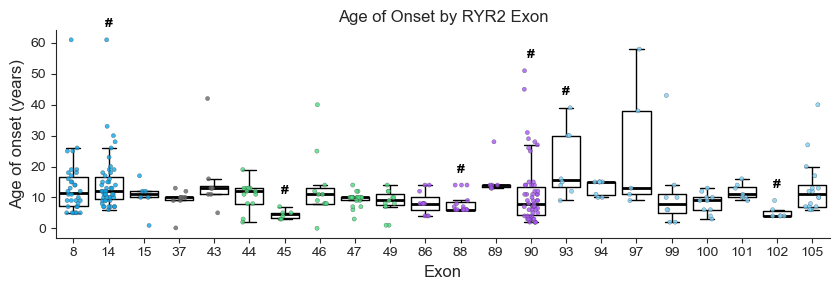

In [71]:
sns.set_style("ticks")
fig_4_c = figure_4.panels["panel_c"]

COLOR_FOR_MEDIAN = cc.glasbey_dark[45]

historical_exon_hotspots = {
    # https://color.adobe.com/ryr2-exon-hotspot-color-theme-7ec4acca-8f7f-4a8a-90c9-beca824664fe/
    (3, 15): {"color": "#0EA5E9", "text": "I"},
    (44, 50): {"color": "#4ADE80", "text": "II"},
    (83, 90): {"color": "#A855F7", "text": "III"},
    (93, 105): {"color": "#7DD3FC", "text": "IV"},
}


def determine_exon_color(exon: int):
    for start, end in historical_exon_hotspots.keys():
        if start <= exon <= end:
            return historical_exon_hotspots[(start, end)]["color"]

    return colors.default_dot


def plot_exons(
        exons_plot_df: pd.DataFrame,
        plot_name: str,
):
    # exons_plot_df = exons_plot_df.copy()
    #
    # exons_plot_df[AGE_OF_ONSET_COL] = np.log2(exons_plot_df[AGE_OF_ONSET_COL])

    y_offset_dots = 5

    plt.figure(figsize=figure_4.fig_size)

    palette_exon = {
        exon: determine_exon_color(exon)
        for exon in exons_plot_df["exon_start"].unique()
    }

    order_exons = sorted(exons_plot_df["exon_start"].unique())
    print(order_exons)

    curr_ax = sns.boxplot(
        data=exons_plot_df,
        y=AGE_OF_ONSET_COL,
        x="exon_start",
        linewidth=1,
        fill=False,
        # width=0.8,
        # palette=palette_exon,
        # hue="exon_start",
        order=order_exons,
        medianprops=colors.box_median_props,
        # linecolor="black",
        color="black",
        #fill=False,
        showfliers=False,
        legend=False,
    )

    add_stars_on_box(
        curr_ax,
        order_exons,
        exon_mw_all,
        [
            np.ceil(exons_plot_df[exons_plot_df["exon_start"] == exon][
                        AGE_OF_ONSET_COL].max())
            for exon in order_exons
        ],
        color="black",
        offset=y_offset_dots,
        stars="#"
    )

    # add scatter plot
    sns.stripplot(
        data=exons_plot_df,
        y=AGE_OF_ONSET_COL,
        x="exon_start",
        color="black",
        alpha=0.8,
        linewidth=0.25,
        size=3,
        jitter=0.2,
        palette=palette_exon,
        hue="exon_start",
        legend=False,
        order=order_exons,
        hue_order=order_exons,
        ax=curr_ax
    )

    # add a dotted line at global median
    # plt.axhline(
    #     df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median(),
    #     color=COLOR_FOR_MEDIAN,
    #     linestyle='dashed',
    #     linewidth=1,
    #     label=f"Median: {df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median():.2f}",
    #     zorder=100
    # )

    # curr_ax.set_ylim(plt.ylim()[0], plt.ylim()[1] + y_offset_dots)

    #plt.yscale("log")

    set_figure_size(
        fig_4_c,
    )

    sns.despine()

    save_current_plot(plot_name)

    plt.show()


plot_exons(filtered_exon_for_analysis, "age_of_onset_vs_exon_mw")
#plot_exons(filtered_exon_wilcoxon, "age_of_onset_vs_exon_log")

## Age of onset vs Domain

In [72]:
# domains
domains_df = pd.read_csv("./data_commit/ryr2_subdomains.csv")

domains_df.head()

,domains,subdomains,subdomain_precedence
0,NTD,NTD-A,NaN
1,SPRY,NTD-B,NaN
2,JSol,NSol,NaN
3,BSol,SPRY1,NaN
4,SCLP,SPRY2,NaN


In [73]:
domain_df, domain_for_analysis, domain_stats = get_filtered_df(
    df_cpvt_analysis,
    group_col="domain",
    change_type_col="protein_change_type",
    min_num_individuals=MIN_NUM_INDIVIDUALS
)

domain_stats

{'n_patients_removed': 2, 'n_cats_analysis': 8, 'n_patients_analysis': 392}

In [74]:
domain_results = get_mann_whitney(
    domain_for_analysis,
    df_all_data=domain_df,
    group_col="domain"
)

domain_results[
    domain_results["qvalue"] < 0.05
    ]

,group,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
2,NTD,17086.0,0.005813,97,297,0.186157,0.593079,small,small,greater,There is a 59.31% chance that a randomly selec...,0.023253
5,CSol,9013.5,0.001342,74,320,-0.238725,0.380638,small,small,less,There is a 61.94% chance that a randomly selec...,0.010740


In [75]:
domain_sum_stats = get_stats_df(domain_for_analysis, 'domain')

domain_stat_order = [
    v for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domain_sum_stats["domain"])
]
domain_sum_stats.set_index("domain", inplace=True)
domain_sum_stats = domain_sum_stats.loc[domain_stat_order]
domain_sum_stats

,mean,median,q1,q3,n
domain,,,,,
NTD,14.071340,12.0,9.00,16.00,97
SPRY,13.200000,12.0,8.75,12.75,10
JSol,9.236667,10.0,9.00,10.00,9
BSol,15.173913,10.0,8.00,14.00,92
CSol,10.777027,8.0,6.00,14.00,74
TaF,13.130435,11.0,6.00,14.50,23
TM,13.095238,10.0,9.00,14.50,63
CTD,13.333333,12.5,7.75,14.25,24


In [76]:
report["domain"] = PdfSection(
    section="Age of Onset vs Domain",
    stuff=[
        f"Number of domains for MW-U: {domain_for_analysis['domain'].nunique()}",
        f"Total patients shown in graph: {domain_stats['n_patients_analysis']}",
        f"Mean (all domains): {domain_df[AGE_OF_ONSET_COL].mean():.2f}",
        f"Median (all domains): {domain_df[AGE_OF_ONSET_COL].median():.2f}. IQR: {domain_df[AGE_OF_ONSET_COL].quantile(0.25):.2f}-{domain_df[AGE_OF_ONSET_COL].quantile(0.75):.2f}",
        f"Total number patients (all domains): {len(domain_df)}\n",
        # *domain_dunn_sig,
        domain_results[
            domain_results["pvalue"] < 0.05
            ]
    ]
)

## Subdomains

In [77]:
sub_domain_df, sub_domain_for_analysis, sub_domain_stats = get_filtered_df(
    df_cpvt_analysis,
    group_col="subdomain",
    change_type_col="protein_change_type",
    min_num_individuals=MIN_NUM_INDIVIDUALS
)

sub_domain_stats

{'n_patients_removed': 13, 'n_cats_analysis': 12, 'n_patients_analysis': 381}

In [78]:
subdomain_stat = get_stats_df(sub_domain_for_analysis, 'subdomain')

subdomain_stat_order = [
    v for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(subdomain_stat["subdomain"])
]

subdomain_stat.set_index("subdomain", inplace=True)
subdomain_stat = subdomain_stat.loc[subdomain_stat_order]

subdomain_stat

,mean,median,q1,q3,n
subdomain,,,,,
NTD-A,13.868421,12.0,8.25,16.75,38
NTD-B,15.333333,12.0,11.00,14.00,9
NSol,13.998400,12.0,9.00,15.75,50
SPRY3,12.428571,12.0,9.50,12.50,7
JSol,9.236667,10.0,9.00,10.00,9
BSol1,14.633333,10.0,8.00,13.00,90
CSol(exEF-hand),9.760870,8.0,6.00,13.00,69
EF1&2,24.800000,28.0,10.00,31.00,5
TaF,13.130435,11.0,6.00,14.50,23


In [79]:
sub_domain_results = get_mann_whitney(
    sub_domain_for_analysis,
    df_all_data=sub_domain_df,
    group_col="subdomain"
)

sub_domain_results[
    sub_domain_results["pvalue"] < 0.05
    ]

,group,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
3,Pore,3611.5,0.018525,27,367,-0.271067,0.364467,small,small,less,There is a 63.55% chance that a randomly selec...,0.111149
6,CSol(exEF-hand),8052.5,0.000229,69,325,-0.281828,0.359086,medium,small,less,There is a 64.09% chance that a randomly selec...,0.002754


In [80]:
report["sub_domain"] = PdfSection(
    section="Age of Onset vs Subdomain",
    stuff=[
        f"Number of subdomains for MW-U: {sub_domain_for_analysis['subdomain'].nunique()}",
        f"Total patients shown in graph: {sub_domain_stats['n_patients_analysis']}",
        f"Mean (all subdomains): {sub_domain_df[AGE_OF_ONSET_COL].mean():.2f}",
        f"Median (all subdomains): {sub_domain_df[AGE_OF_ONSET_COL].median():.2f}. IQR: {sub_domain_df[AGE_OF_ONSET_COL].quantile(0.25):.2f}-{sub_domain_df[AGE_OF_ONSET_COL].quantile(0.75):.2f}",
        f"Total number patients (all subdomains): {len(sub_domain_df)}",
        sub_domain_results[
            sub_domain_results["pvalue"] < 0.05
            ]
    ]
)

## Save Report

In [81]:
domain_stat_and_p = get_stats_df(domain_df, 'domain').join(
    domain_results.set_index("group"),
    on="domain",
    how="outer"
)


def round_to_sig_figs(df_input: pd.DataFrame, sig_figs: int = 1, p_sf: int = 3):
    df_input["mean"] = df_input["mean"].round(sig_figs)
    df_input["median"] = df_input["median"].round(sig_figs)
    df_input["q1"] = df_input["q1"].round(sig_figs)
    df_input["q3"] = df_input["q3"].round(sig_figs)

    df_input["pvalue"] = df_input["pvalue"].round(p_sf)
    df_input["qvalue"] = df_input["qvalue"].round(p_sf)

    return df_input


domain_stat_and_p.set_index("domain", inplace=True)
domain_stat_and_p = domain_stat_and_p.loc[[
    v for v in domains_df["domains"].dropna().str.strip().values
    if v in set(domain_stat_and_p.index)
]]

domain_stat_and_p = round_to_sig_figs(domain_stat_and_p)

domain_stat_and_p

,mean,median,q1,q3,n,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
domain,,,,,,,,,,,,,,,,
NTD,14.1,12.0,9.0,16.0,97,17086.0,0.006,97.0,297.0,0.186157,0.593079,small,small,greater,There is a 59.31% chance that a randomly selec...,0.023
SPRY,13.2,12.0,8.8,12.8,10,2010.0,0.801,10.0,384.0,0.046875,0.523438,None,None,greater,There is a 52.34% chance that a randomly selec...,0.885
JSol,9.2,10.0,9.0,10.0,9,1423.0,0.359,9.0,385.0,-0.178644,0.410678,small,small,less,There is a 58.93% chance that a randomly selec...,0.685
BSol,15.2,10.0,8.0,14.0,92,14030.0,0.885,92.0,302.0,0.009934,0.504967,None,None,greater,There is a 50.50% chance that a randomly selec...,0.885
SCLP,36.0,36.0,26.5,45.5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CSol,10.8,8.0,6.0,14.0,74,9013.5,0.001,74.0,320.0,-0.238725,0.380638,small,small,less,There is a 61.94% chance that a randomly selec...,0.011
TaF,13.1,11.0,6.0,14.5,23,3847.0,0.428,23.0,371.0,-0.098324,0.450838,None,None,less,There is a 54.92% chance that a randomly selec...,0.685
TM,13.1,10.0,9.0,14.5,63,10279.0,0.859,63.0,331.0,-0.014147,0.492927,None,None,less,There is a 50.71% chance that a randomly selec...,0.885
CTD,13.3,12.5,7.8,14.2,24,4918.5,0.376,24.0,370.0,0.107770,0.553885,None,None,greater,There is a 55.39% chance that a randomly selec...,0.685


In [82]:
subdomain_stat_and_p = get_stats_df(sub_domain_df, 'subdomain').join(
    sub_domain_results.set_index("group"),
    on="subdomain",
    how="outer"
)
subdomain_stat_and_p = subdomain_stat_and_p.set_index("subdomain")
# subdomain_stat_order = [
#     v for v in domains_df["subdomains"].dropna().str.strip().values
#     if v in set(subdomain_stat["subdomain"])
# ]
subdomain_stat_and_p = subdomain_stat_and_p.loc[[
    v for v in domains_df["subdomains"].dropna().str.strip().values
    if v in set(subdomain_stat_and_p.index)
]]

subdomain_stat_and_p = round_to_sig_figs(subdomain_stat_and_p)

subdomain_stat_and_p.head()

,mean,median,q1,q3,n,u_statistic,pvalue,n_in_group,n_out_group,cliff_delta,vda,effect_size (cliff),effect_size (vda),direction,interpretation,qvalue
subdomain,,,,,,,,,,,,,,,,
NTD-A,13.9,12.0,8.2,16.8,38,7534.5,0.248,38.0,356.0,0.113912,0.556956,small,None,greater,There is a 55.70% chance that a randomly selec...,0.425
NTD-B,15.3,12.0,11.0,14.0,9,2325.0,0.079,9.0,385.0,0.341991,0.670996,medium,medium,greater,There is a 67.10% chance that a randomly selec...,0.238
NSol,14.0,12.0,9.0,15.8,50,9918.5,0.079,50.0,344.0,0.153314,0.576657,small,small,greater,There is a 57.67% chance that a randomly selec...,0.238
SPRY1,12.0,12.0,12.0,12.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPRY2,3.0,3.0,3.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
with pd.ExcelWriter(
        figures_dir / "age_of_onset_stats_domains.xlsx",
        engine="openpyxl",
        mode="w"
) as writer:
    domain_stat_and_p.to_excel(writer, index=True, sheet_name="domains")
    subdomain_stat_and_p.to_excel(writer, index=True, sheet_name="subdomains")
    exon_with_stats.to_excel(writer, index=True, sheet_name="exons")

In [84]:
# age of onset selected variants
variants = [
    "R420Q",
    "R420W"
]

median_var = {}
for variant in variants:
    df_variant = df_cpvt_analysis[
        df_cpvt_analysis["p_hgvs_aa1"] == variant
        ]

    median_var[variant] = {
        "median": df_variant[AGE_OF_ONSET_COL].median(),
        "n": len(df_variant[
                     df_variant[AGE_OF_ONSET_COL].notnull()
                 ])
    }

    print(
        f"{variant}: {median_var[variant]["median"]:.2f} n={median_var[variant]['n']}")

report["selected_variants"] = PdfSection(
    section="Age of Onset for Selected Variants",
    stuff=[
        f"{variant}: {median_var[variant]['median']:.2f} n={median_var[variant]['n']}"
        for variant in variants
    ]
)


R420Q: 10.00 n=26
R420W: 18.50 n=8


In [85]:
from analysis.write_report import write_sections_to_pdf
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

# report
pdf_name = figures_dir / "age_of_onset.pdf"

# Create PDF and write content
c = canvas.Canvas(str(pdf_name), pagesize=A4)
write_sections_to_pdf(c, list(report.values()))
c.save()

print(f"PDF saved to {pdf_name}")

PDF saved to ../figures/0_3_3/analysis_06_mann_whitney/age_of_onset.pdf


## Figures

In [86]:
# use colors from chimerax
# https://color.adobe.com/RYR-domains-palette---for-bar-color-theme-1418b1f4-054c-4360-98ce-52705766067c/
# AA for white background
dark_color_palette = {
    # opt for display on white background
    "ntd": "#0E7490",
    "spry": "#C2410C",
    "jsol": "#B242B3",
    "bsol": "#713F12",
    "sclp": "#4D7C0F",
    "csol": "#1575BC",
    "taf": "#9F1239",
    "tm": "#4B5563",
    "ctd": "#064E3B"
}

# https://color.adobe.com/RYR-domains-palette---black-text-color-theme-d489fbc0-974a-4e0e-a776-dbf4c246cde9/
# for filled bars - opt for black on color
# AAA for dark text on color
light_color_palette = {
    "ntd": "#C7D2FE",
    "spry": "#FB923C",
    "jsol": "#A78BFA",
    "bsol": "#FEF08A",
    "sclp": "#A3E635",
    "csol": "#06B6D4",
    "taf": "#FB7185",
    "tm": "#CCCACC",
    "ctd": "#22C55E"
}
COLOR_FOR_MEDIAN

'#4d33ff'

In [87]:
domain_to_subdomain = df_cpvt_analysis[[
    "domain",
    "subdomain",
]].drop_duplicates(
    subset=["domain", "subdomain"]
).sort_values(
    by=["domain", "subdomain"]
).dropna()

domain_to_subdomain.head()

,domain,subdomain
18,BSol,BSol1
375,BSol,BSol2
103,BSol,RY3&4
139,CSol,CSol(exEF-hand)
11,CSol,EF1&2


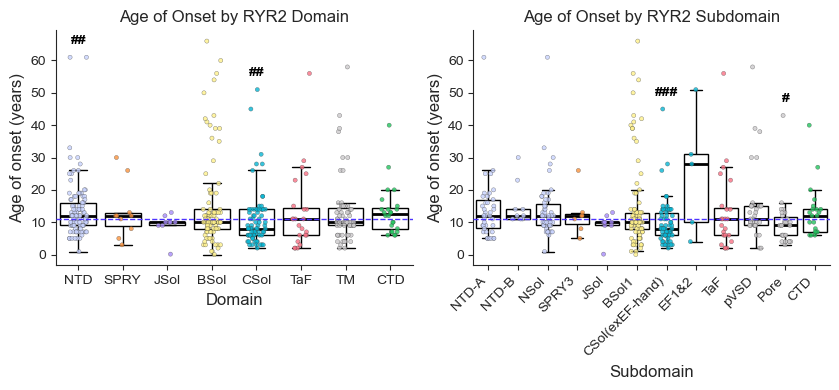

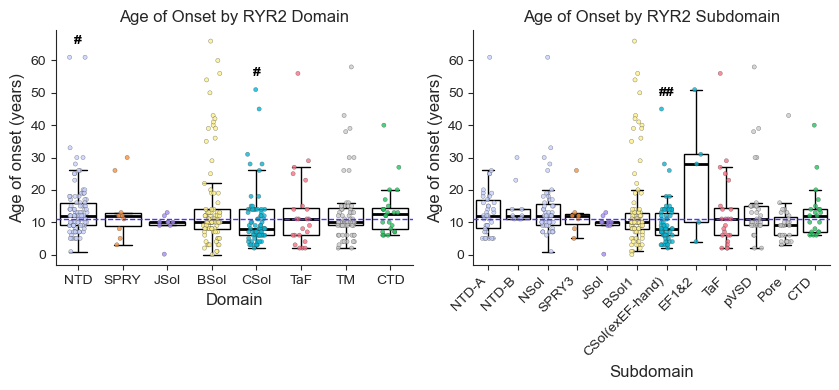

In [88]:
from matplotlib.gridspec import GridSpec

figure_6 = get_config().figure6


def add_significance_lines(*,
                           p_value: float,
                           ax_curr: plt.Axes,
                           structure_order: list[str],
                           domain1: str,
                           domain2: str
                           ):
    p_str = convert_pvalue_to_asterisks(p_value)

    if p_str == "":
        return

    domain1_idx = structure_order.index(domain1)
    domain2_idx = structure_order.index(domain2)

    y_range = plt.ylim()[1] - plt.ylim()[0]

    y_pos = plt.ylim()[1] + (y_range) * 0.05

    ax_curr.plot(
        [domain1_idx, domain2_idx],
        [y_pos, y_pos],
        color="black",
        lw=1
    )
    ax_curr.plot(
        [domain1_idx, domain1_idx],
        [y_pos, y_pos - 1],
        color="black",
        lw=1
    )
    ax_curr.plot(
        [domain2_idx, domain2_idx],
        [y_pos, y_pos - 1],
        color="black",
        lw=1
    )

    ax_curr.text(
        (domain1_idx + domain2_idx) / 2,
        y_pos,
        p_str,
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold"
    )


def plot_boxplots(
        df_for_structure: pd.DataFrame,
        *,
        column: str,
        box_palette: dict[str, str],
        dot_palette: dict[str, str],
        structure_order: list[str],
        ax_input: plt.Axes,
        panel_sel: str,
        x_tick_rotation: int = 0,
        x_tick_ha: Literal["center", "right", "left"] = "center",
        results_stats: pd.DataFrame,
        box_fill: bool,
        sig_value: Literal["pvalue", "qvalue"],
):
    sns.boxplot(
        data=df_for_structure,
        y=AGE_OF_ONSET_COL,
        x=column,
        fill=box_fill,
        palette=box_palette,
        hue=column,
        medianprops={
            "linewidth": 2
        },
        legend=False,
        order=structure_order,
        showfliers=False,
        ax=ax_input,
        linecolor="black"
    )

    sns.stripplot(
        data=df_for_structure,
        y=AGE_OF_ONSET_COL,
        x=column,
        hue=column,
        hue_order=structure_order,
        order=structure_order,
        palette=dot_palette,
        linewidth=0.25,
        alpha=colors.dot_alpha,
        size=3,
        jitter=0.2,
        ax=ax_input
    )

    # add a dotted line at global median
    plt.axhline(
        df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median(),
        color=COLOR_FOR_MEDIAN,
        linestyle='dashed',
        linewidth=1,
        label=f"Median: {df_cpvt_unique_by_patient[AGE_OF_ONSET_COL].median():.2f}",
        zorder=100
    )

    add_stars_on_box(
        ax_input,
        structure_order,
        results_stats,
        [
            np.ceil(df_for_structure[df_for_structure[column] == structure][
                        AGE_OF_ONSET_COL].max())
            for structure in structure_order
        ],
        stars="#",
        sig_value=sig_value
    )

    set_figure_size(
        figure_6.panels[panel_sel],
        x_tick_rotation=x_tick_rotation,
        x_tick_ha=x_tick_ha
    )


sns.set_style("ticks")


def generate_palettes(
        input_pal: dict[str, str],
):
    # color pallete for plotting
    domain_color_pal = {
        domain: input_pal[domain.lower()]
        for domain in domain_stat_order
    }

    subdomain_color_pal = {
        row["subdomain"]: input_pal[
            row["domain"].lower().strip()
        ]
        for _, row in domain_to_subdomain[
            domain_to_subdomain["subdomain"].isin(
                sub_domain_for_analysis["subdomain"].unique()
            )
        ].iterrows()
    }

    return domain_color_pal, subdomain_color_pal


def create_fig_6(
        *,
        box_palette: dict[str, str],
        dot_palette: dict[str, str],
        box_fill: bool = False,
        sig_value: Literal["pvalue", "qvalue"]
):
    # color pallete for plotting
    domain_color_box_pal, subdomain_color_box_pal = generate_palettes(
        box_palette
    )
    domain_color_dot_pal, subdomain_color_dot_pal = generate_palettes(
        dot_palette
    )

    fig = plt.figure(figsize=figure_6.fig_size)
    gs = GridSpec(1, 2, figure=fig)

    # First plot
    ax1 = fig.add_subplot(gs[0, 0])
    plot_boxplots(
        domain_for_analysis,
        column="domain",
        box_palette=domain_color_box_pal,
        dot_palette=domain_color_dot_pal,
        structure_order=domain_stat_order,
        ax_input=ax1,
        panel_sel="panel_c",
        results_stats=domain_results,
        box_fill=box_fill,
        sig_value=sig_value
    )

    ax2 = fig.add_subplot(gs[0, 1])
    plot_boxplots(
        sub_domain_for_analysis,
        column="subdomain",
        box_palette=subdomain_color_box_pal,
        dot_palette=subdomain_color_dot_pal,
        structure_order=subdomain_stat_order,
        ax_input=ax2,
        panel_sel="panel_d",
        x_tick_rotation=45,
        x_tick_ha="right",
        results_stats=sub_domain_results,
        box_fill=box_fill,
        sig_value=sig_value
    )
    #plt.yscale("log")

    fig.tight_layout()

    save_current_plot(
        f"age_of_onset_vs_domain_subdomain{"-with-fdr" if sig_value == "qvalue" else "unadjusted"}.v2")

    plt.show()

    plt.close()


# create_fig_6(box_palette=dark_color_palette, dot_palette=dark_color_palette,
#              box_fill=False)
create_fig_6(box_palette={
    d: "white" for d in light_color_palette
}, dot_palette=light_color_palette,
    box_fill=True, sig_value="pvalue")

create_fig_6(box_palette={
    d: "white" for d in light_color_palette
}, dot_palette=light_color_palette,
    box_fill=True, sig_value="qvalue")